# Sentiment Analysis on Restaurants Reviews

# Introduction

- Natural language processing (NLP) is a subfield of computer science and artificial intelligence concerned with the interactions between computers and human (natural) languages.
- In this project, we will try to analyse the sentiments of Reviewers using machine learning which will help in identifying whether a given review is a positive or negative.

# Context

- Most of the Restaurants ask reviews to the customers and based on the reviews the restaurant can improve the customer satisfaction. So Reviews plays a vital role for the successful growth of the restaurant.

# Content

- The dataset consists of 1000 rows and 2 columns. Review Column consist of customer reviews and like column consist of 0 and 1. If the review is positive, 1 and if negative, 0.

# Importing Dependencies

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sk-learn Libraries 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# NLP Libraries
import re
import itertools
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Other Libraries
import string
from collections import Counter

# Keras Libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

# 2. Reading the dataset

In [2]:
# Use correct separator as data is tabular separated.

reviews_data = pd.read_csv('Restaurant_Reviews.tsv', sep = '\t', quoting = 3)
reviews_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


# 3. Exploratory Data Analysis (EDA)

In [3]:
# Let's check out some of the stats with some plots and the built-in methods in pandas!
reviews_data.describe()

,Liked
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [4]:
# Let's use groupby to use describe by Liked, this way we can begin to think about the features that separate 
# Positive or Negative!

reviews_data.groupby('Liked').describe()

Review                                    
       count unique                     top freq
Liked                                           
0        500    497  The food was terrible.    2
1        500    499      I love this place.    2

**Observations:**
- Here some Duplicate rows are observed. So, lets remove them.

In [5]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
reviews_data.drop_duplicates(inplace = True)

In [7]:
reviews_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [8]:
reviews_data.groupby('Liked').describe()

Review                                                               
       count unique                                                top freq
Liked                                                                      
0        497    497  Why are these sad little vegetables so overcoo...    1
1        499    499                          Awesome service and food.    1

In [9]:
# Let's make a new column to detect how long reviews are:
reviews_data['review_length'] = reviews_data['Review'].apply(len)
reviews_data.head()

,Review,Liked,review_length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


In [10]:
# Analysing the 'review_length' feature
reviews_data['review_length'].describe()

count    996.000000
mean      58.459839
std       32.341292
min       11.000000
25%       33.000000
50%       51.000000
75%       80.000000
max      149.000000
Name: review_length, dtype: float64

In [11]:
# Max is 149 characters, let's use masking to find this review
reviews_data[reviews_data['review_length'] == 149]['Review'].iloc[0]

'The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).'

[Text(0.5, 0, 'Length of Review'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Negative Reviews')]

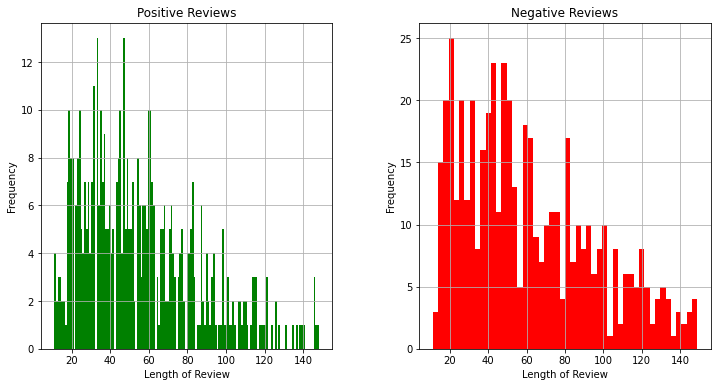

In [12]:
# Lets see if message length is a distinguishing feature between ham and spam:

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

reviews_data[reviews_data['Liked'] == 1].hist(column = 'review_length', bins = 150, ax = ax[0], color = 'green')
ax[0].set(xlabel = 'Length of Review', ylabel = 'Frequency', title = 'Positive Reviews')

reviews_data[reviews_data['Liked'] == 0].hist(column = 'review_length', bins = 50, ax = ax[1], color = 'red')
ax[1].set(xlabel = 'Length of Review', ylabel = 'Frequency', title = 'Negative Reviews')

**Observations:**
- As expected Through the basic EDA we've seen that no seperation or trend has observed using 'review_length' feature.

# 4. Preprocessing

- Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task.
- There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

## Data Cleaning

- text_preprocessing() function takes a sentence as it’s input and returns a cleaned sentence. This function takes care of the following

In [13]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [14]:
# Defining Certain Functions
def text_preprocessing(review):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    
    STOPWORDS = set(stopwords.words('english')) - set(['not', "aren't", "couldn't", "didn't", "doesn't", "don't"
                                                       "hadn't", "haven't", "isn't", "shan't", "needn't", "shouldn't"
                                                       "wasn't", "wouldn't"])
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in review if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [15]:
# Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the
# normal text strings in to a list of tokens (words that we actually want).

reviews_data['cleaned_review'] = reviews_data.Review.apply(text_preprocessing)
reviews_data.head()

,Review,Liked,review_length,cleaned_review
0,Wow... Loved this place.,1,24,Wow Loved place
1,Crust is not good.,0,18,Crust not good
2,Not tasty and the texture was just nasty.,0,41,Not tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,87,Stopped late May bank holiday Rick Steve recom...
4,The selection on the menu was great and so wer...,1,59,selection menu great prices


In [16]:
# Lets visualise the most_common words from the data

In [17]:
words = reviews_data[reviews_data.Liked == 1].cleaned_review.apply(lambda x: [word.lower() for word in x.split()])
positive_review_words = Counter()

for msg in words:
    positive_review_words.update(msg)
    
print(positive_review_words.most_common(50))

[('good', 73), ('great', 70), ('food', 60), ('place', 56), ('service', 46), ('friendly', 23), ('delicious', 23), ('back', 23), ('nice', 22), ('time', 22), ('really', 22), ('best', 22), ('amazing', 21), ('also', 18), ('not', 18), ('like', 17), ('restaurant', 17), ('go', 17), ('staff', 15), ('love', 15), ('vegas', 15), ('first', 13), ('menu', 12), ('always', 12), ('fantastic', 12), ('experience', 12), ('awesome', 12), ('pretty', 11), ('made', 11), ('loved', 10), ('chicken', 10), ('definitely', 10), ('fresh', 10), ('one', 10), ('steak', 10), ('excellent', 10), ('even', 10), ('pizza', 10), ('perfect', 10), ('prices', 9), ('server', 9), ('ever', 9), ('im', 9), ('atmosphere', 9), ('selection', 8), ('could', 8), ('tasty', 8), ('came', 8), ('stars', 8), ('well', 8)]


In [18]:
words = reviews_data[reviews_data.Liked == 0].cleaned_review.apply(lambda x: [word.lower() for word in x.split()])
negative_review_words = Counter()

for msg in words:
    negative_review_words.update(msg)
    
print(negative_review_words.most_common(50))

[('not', 97), ('food', 63), ('place', 48), ('back', 37), ('service', 37), ('like', 29), ('go', 26), ('dont', 25), ('good', 22), ('never', 22), ('time', 20), ('would', 20), ('ever', 19), ('minutes', 19), ('bad', 18), ('one', 16), ('much', 15), ('got', 15), ('really', 14), ('disappointed', 14), ('wont', 14), ('worst', 13), ('think', 13), ('going', 13), ('wasnt', 13), ('ive', 13), ('came', 12), ('eat', 12), ('us', 12), ('im', 12), ('slow', 11), ('get', 11), ('wait', 11), ('bland', 11), ('better', 11), ('well', 10), ('way', 10), ('waited', 10), ('flavor', 10), ('probably', 10), ('didnt', 9), ('times', 9), ('ordered', 9), ('also', 9), ('another', 9), ('even', 9), ('terrible', 9), ('could', 8), ('say', 8), ('overpriced', 8)]


**Observations:**
- From the above list the positive words and negative words are well seperated. So, we are on the right track

### Train_Test_Splitting

In [19]:
x = reviews_data.cleaned_review
y = reviews_data.Liked
print(x.shape)
print(y.shape)

(996,)
(996,)


In [20]:
# split X and y into training and testing sets 

x_train, x_test, y_train, y_test = train_test_split (x, y, random_state = 1, test_size = 0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(796,)
(200,)
(796,)
(200,)


In [21]:
x_train

908                                       wont returning
905           Also feel like chips bought not made house
982                                         Food average
47                         burger good beef cooked right
748    watched prices inflate portions get smaller ma...
                             ...                        
767                                        block amazing
72                                           service meh
912    felt insulted disrespected could talk judge an...
235                       possible give zero stars theyd
37     Poor service waiter made feel like stupid ever...
Name: cleaned_review, Length: 796, dtype: object

In [22]:
y_train

908    0
905    0
982    0
47     1
748    0
      ..
767    1
72     0
912    0
235    0
37     0
Name: Liked, Length: 796, dtype: int64

In [23]:
x_test

358                              Best fish Ive ever life
607                                         wanted leave
809    first time ever came amazing experience still ...
920            Needless say wont going back anytime soon
242             time side restaurant almost empty excuse
                             ...                        
429        nicest restaurant owners Ive ever come across
891              rotating beers tap also highlight place
577                          Service good company better
654                            patio seating comfortable
207                                WORST EXPERIENCE EVER
Name: cleaned_review, Length: 200, dtype: object

In [24]:
y_test

358    1
607    0
809    1
920    0
242    0
      ..
429    1
891    1
577    1
654    1
207    0
Name: Liked, Length: 200, dtype: int64

## Vectorization

### 1. Bag - of - Words 

- Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

- Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

- We'll do that in three steps using the bag-of-words model:
    1. Count how many times does a word occur in each message (Known as term frequency)
    2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
    3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)


In [25]:
# Instantiate the vectorizer
cv = CountVectorizer(stop_words = STOPWORDS, ngram_range = (1, 3), max_df = 0.5, min_df = 2)

# Learn the training data vocabulary, then use it to create a document-term matrix
bow_train = cv.fit_transform(x_train)
bow_train

<796x820 sparse matrix of type '<class 'numpy.int64'>'
	with 3787 stored elements in Compressed Sparse Row format>

In [26]:
print('Shape of Sparse Matrix: ', bow_train.shape)
print('Amount of Non-Zero occurences: ', bow_train.nnz)

Shape of Sparse Matrix:  (796, 820)
Amount of Non-Zero occurences:  3787


In [27]:
# Transform test data (using fitted vocabulary) into a document-term matrix
bow_test = cv.transform(x_test)
bow_test

<200x820 sparse matrix of type '<class 'numpy.int64'>'
	with 811 stored elements in Compressed Sparse Row format>

In [28]:
print('Shape of Sparse Matrix: ', bow_test.shape)
print('Amount of Non-Zero occurences: ', bow_test.nnz)

Shape of Sparse Matrix:  (200, 820)
Amount of Non-Zero occurences:  811


### 2. TF-IDF

- TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. 
- This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 
- The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 
- Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

In [29]:
# Instantiate the vectorizer
tv = TfidfTransformer()

# Learn the training data vocabulary, then use it to create a document-term matrix
tfidf_train = tv.fit_transform(bow_train)
tfidf_train

<796x820 sparse matrix of type '<class 'numpy.float64'>'
	with 3787 stored elements in Compressed Sparse Row format>

In [30]:
print('Shape of Sparse Matrix: ', tfidf_train.shape)
print('Amount of Non-Zero occurences: ', tfidf_train.nnz)

Shape of Sparse Matrix:  (796, 820)
Amount of Non-Zero occurences:  3787


In [31]:
# Transform test data (using fitted vocabulary) into a document-term matrix
tfidf_test = tv.transform(bow_test)
tfidf_test

<200x820 sparse matrix of type '<class 'numpy.float64'>'
	with 811 stored elements in Compressed Sparse Row format>

In [32]:
print('Shape of Sparse Matrix: ', tfidf_test.shape)
print('Amount of Non-Zero occurences: ', tfidf_test.nnz)

Shape of Sparse Matrix:  (200, 820)
Amount of Non-Zero occurences:  811


 # 5. Building and evaluating a model

### 1. Naive Bayes

- The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
- The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
- It is the baseline model for NLP classification process 

#### Training

In [33]:
# Instantiate the classifier
nb = MultinomialNB()

# train the model using tfidf_train (timing it with an IPython "magic command")
%time nb.fit(tfidf_train, y_train)

Wall time: 3.98 ms


MultinomialNB()

#### Evaluation

In [34]:
# Make class predictions for tfidf_test
y_pred_nb = nb.predict(tfidf_test)

In [35]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_nb)

0.71

In [36]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_nb)

array([[78, 37],
       [21, 64]], dtype=int64)

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 71% on unseen data.

In [37]:
# Print message text for false positives (Negative reviews incorrectly classifier)
x_test[(y_pred_nb == 1) & (y_test == 0)]
# x_test[y_pred_nb > y_test]

242             time side restaurant almost empty excuse
862    Hot dishes not hot cold dishes close room temp...
6                             Honeslty didnt taste fresh
495                                       tragedy struck
954                         fries not hot neither burger
784                      chains Im fan beat place easily
94                                  say bye bye tip lady
41         not deal good enough would drag establishment
422    Furthermore cant even find hours operation web...
148                                        give 2 thumbs
238      not rolled eyes may stayed Not sure go back try
731    Ryans Bar definitely one Edinburgh establishme...
754    Main thing didnt enjoy crowd older crowd aroun...
951    tables outside also dirty lot time workers not...
936           sangria half glass wine full 12 ridiculous
970    immediately said wanted talk manager not want ...
589                                 kids play area NASTY
705    work hospitality industr

In [38]:
# Print message text for false negatives (Positive Reviews incorrectly classifier)
x_test[(y_pred_nb == 0) & (y_test == 1)]
# x_test[y_pred_nb < y_test]

358                              Best fish Ive ever life
404    Today first taste Buldogis Gourmet Hot Dog tel...
104                                   one better buffets
512                            far BEST cheesecurds ever
108                                    go back next trip
493                             CONCLUSION filling meals
718                                      one bite hooked
101    good thing waiter helpful kept bloddy marys co...
34                                Overall like place lot
604                          Couldnt ask satisfying meal
799                     get inside youll impressed place
527    sure order dessert even need pack togo tiramis...
395    summarize food incredible nay transcendant not...
739                              Never anything complain
745    warm feeling service felt like guest special t...
258                                            know make
248                        lighting dark enough set mood
857    may say buffet pricey th

In [39]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_nb)

0.7156010230179028

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 97.04% on unseen data by using Multinomial Naive Bayes.

### 2. Logistic Regression

- Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. 
- In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

#### Training

In [40]:
# Instantiate the classifier
log_reg = LogisticRegression(solver = 'liblinear')

# train the model using tfidf_train (timing it with an IPython "magic command")
%time log_reg.fit(tfidf_train, y_train)

Wall time: 387 ms


LogisticRegression(solver='liblinear')

#### Evaluation

In [41]:
# Make class predictions for tfidf_test
y_pred_lr = log_reg.predict(tfidf_test)

In [42]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_lr)

0.725

In [43]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_lr)

array([[85, 30],
       [25, 60]], dtype=int64)

In [44]:
# print message text for false positives (Positive reviews incorrectly classifier)
x_test[(y_pred_lr == 1) & (y_test==0)]
# x_test[y_pred_nb > y_test]

242             time side restaurant almost empty excuse
6                             Honeslty didnt taste fresh
954                         fries not hot neither burger
784                      chains Im fan beat place easily
41         not deal good enough would drag establishment
422    Furthermore cant even find hours operation web...
148                                        give 2 thumbs
238      not rolled eyes may stayed Not sure go back try
731    Ryans Bar definitely one Edinburgh establishme...
960    Insults profound deuchebaggery go outside smok...
754    Main thing didnt enjoy crowd older crowd aroun...
951    tables outside also dirty lot time workers not...
599                                       Not good money
636                              Tried go lunch madhouse
970    immediately said wanted talk manager not want ...
523                                first time might last
236    descriptions said yum yum sauce another said e...
455    chicken wings contained 

In [45]:
# print message text for false negatives (Negative reviews incorrectly classifier)
x_test[(y_pred_lr == 0) & (y_test == 1)]
# x_test[y_pred_lr < y_test]

358                              Best fish Ive ever life
404    Today first taste Buldogis Gourmet Hot Dog tel...
104                                   one better buffets
512                            far BEST cheesecurds ever
108                                    go back next trip
493                             CONCLUSION filling meals
718                                      one bite hooked
101    good thing waiter helpful kept bloddy marys co...
34                                Overall like place lot
604                          Couldnt ask satisfying meal
661                         convenient since staying MGM
799                     get inside youll impressed place
527    sure order dessert even need pack togo tiramis...
395    summarize food incredible nay transcendant not...
667    chef generous time even came around twice take...
255                          7 table service pretty fast
739                              Never anything complain
745    warm feeling service fel

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 72.50% on unseen data by using Logistic Regression. Slight improvement in the accuracy has observed.

### 3. SVM

#### Training

In [46]:
# Instantiate the classifier
svms = SVC()

# train the model using tfidf_train (timing it with an IPython "magic command")
%time svms.fit(tfidf_train, y_train)

Wall time: 196 ms


SVC()

#### Evaluation

In [47]:
# Make class predictions for tfidf_test
y_pred_svm = svms.predict(tfidf_test)

In [48]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_svm)

0.715

In [49]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_svm)

array([[84, 31],
       [26, 59]], dtype=int64)

In [50]:
# print message text for false positives (Positive reviews incorrectly classifier)
x_test[(y_pred_svm == 1) & (y_test==0)]
# x_test[y_pred_svm > y_test]

607                                         wanted leave
242             time side restaurant almost empty excuse
862    Hot dishes not hot cold dishes close room temp...
6                             Honeslty didnt taste fresh
954                         fries not hot neither burger
784                      chains Im fan beat place easily
41         not deal good enough would drag establishment
422    Furthermore cant even find hours operation web...
148                                        give 2 thumbs
238      not rolled eyes may stayed Not sure go back try
731    Ryans Bar definitely one Edinburgh establishme...
960    Insults profound deuchebaggery go outside smok...
754    Main thing didnt enjoy crowd older crowd aroun...
951    tables outside also dirty lot time workers not...
599                                       Not good money
636                              Tried go lunch madhouse
970    immediately said wanted talk manager not want ...
523                            

In [51]:
# print message text for false negatives (Negative reviews incorrectly classifier)
x_test[(y_pred_svm == 0) & (y_test == 1)]
# x_test[y_pred_svm < y_test]

358                              Best fish Ive ever life
404    Today first taste Buldogis Gourmet Hot Dog tel...
104                                   one better buffets
512                            far BEST cheesecurds ever
108                                    go back next trip
493                             CONCLUSION filling meals
101    good thing waiter helpful kept bloddy marys co...
34                                Overall like place lot
604                          Couldnt ask satisfying meal
35              redeeming quality restaurant inexpensive
799                     get inside youll impressed place
527    sure order dessert even need pack togo tiramis...
241                                dish quite flavourful
395    summarize food incredible nay transcendant not...
255                          7 table service pretty fast
739                              Never anything complain
745    warm feeling service felt like guest special t...
258                            

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 71.50% on unseen data by using Support Vector Machines.

### 4. Random Forest Classifier

#### Training

In [52]:
# Instantiate the classifier
rf = RandomForestClassifier()

# train the model using tfidf_train (timing it with an IPython "magic command")
%time rf.fit(tfidf_train, y_train)

Wall time: 327 ms


RandomForestClassifier()

#### Evaluation

In [53]:
# Make class predictions for tfidf_test
y_pred_rf = rf.predict(tfidf_test)

In [54]:
# Calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_rf)

0.735

In [55]:
# Print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_rf)

array([[92, 23],
       [30, 55]], dtype=int64)

In [56]:
# print message text for false positives (Positive reviews incorrectly classifier)
x_test[(y_pred_rf == 1) & (y_test==0)]
# x_test[y_pred_rf > y_test]

242             time side restaurant almost empty excuse
6                             Honeslty didnt taste fresh
954                         fries not hot neither burger
784                      chains Im fan beat place easily
41         not deal good enough would drag establishment
148                                        give 2 thumbs
238      not rolled eyes may stayed Not sure go back try
960    Insults profound deuchebaggery go outside smok...
754    Main thing didnt enjoy crowd older crowd aroun...
951    tables outside also dirty lot time workers not...
636                              Tried go lunch madhouse
523                                first time might last
791                                     food arrives meh
194    Im not really sure Joeys voted best hot dog Va...
2                                Not tasty texture nasty
554    However recent experience particular location ...
56     Heart Attack Grill downtown Vegas absolutely f...
228                            

In [57]:
# print message text for false negatives (Negative reviews incorrectly classifier)
x_test[(y_pred_rf == 0) & (y_test == 1)]
# x_test[y_pred_rf < y_test]

358                              Best fish Ive ever life
404    Today first taste Buldogis Gourmet Hot Dog tel...
49     side Greek salad Greek dressing tasty pita hum...
104                                   one better buffets
780                          pretty satifying experience
108                                    go back next trip
493                             CONCLUSION filling meals
34                                Overall like place lot
604                          Couldnt ask satisfying meal
661                         convenient since staying MGM
799                     get inside youll impressed place
527    sure order dessert even need pack togo tiramis...
241                                dish quite flavourful
395    summarize food incredible nay transcendant not...
667    chef generous time even came around twice take...
255                          7 table service pretty fast
739                              Never anything complain
745    warm feeling service fel

**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 74.% on unseen data by using Random Forest which is happened to be Best Accuracy till now.

## 5. LSTMs

In [58]:
reviews_data.head()

,Review,Liked,review_length,cleaned_review
0,Wow... Loved this place.,1,24,Wow Loved place
1,Crust is not good.,0,18,Crust not good
2,Not tasty and the texture was just nasty.,0,41,Not tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,87,Stopped late May bank holiday Rick Steve recom...
4,The selection on the menu was great and so wer...,1,59,selection menu great prices


#### Train-Test Splitting for applying LSTMs.

In [59]:
x = reviews_data.Review
y = reviews_data.Liked
print(x.shape)
print(y.shape)

(996,)
(996,)


In [60]:
# split X and y into training and testing sets 

x_train, x_test, y_train, y_test = train_test_split (x, y, random_state = 1, test_size = 0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(796,)
(200,)
(796,)
(200,)


In [61]:
x_train

908                               We won't be returning.
905    Also, I feel like the chips are bought, not ma...
982                              Food was below average.
47           The burger is good beef, cooked just right.
748    I have watched their prices inflate, portions ...
                             ...                        
767                               The block was amazing.
72                                  The service was meh.
912    i felt insulted and disrespected, how could yo...
235    If it were possible to give them zero stars, t...
37     Poor service, the waiter made me feel like I w...
Name: Review, Length: 796, dtype: object

In [62]:
x_test

358                  Best fish I've ever had in my life!
607                              I just wanted to leave.
809    The first time I ever came here I had an amazi...
920    Needless to say, I won't be going back anytime...
242    By this time our side of the restaurant was al...
                             ...                        
429    These are the nicest restaurant owners I've ev...
891    Their rotating beers on tap is also a highligh...
577         Service was good and the company was better!
654              The patio seating was very comfortable.
207                           The WORST EXPERIENCE EVER.
Name: Review, Length: 200, dtype: object

In [63]:
y_train

908    0
905    0
982    0
47     1
748    0
      ..
767    1
72     0
912    0
235    0
37     0
Name: Liked, Length: 796, dtype: int64

In [64]:
y_test

358    1
607    0
809    1
920    0
242    0
      ..
429    1
891    1
577    1
654    1
207    0
Name: Liked, Length: 200, dtype: int64

#### Process the data

- Tokenize the data and convert the text to sequences.
- Add padding to ensure that all the sequences have the same shape.
- There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [73]:
max_words = 500
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(x_train)

sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = max_len)

#### RNN

In [74]:
# Defining the RNN structure.
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    
    layer = Embedding(max_words, 50, input_length = max_len)(inputs)
    
    layer = LSTM(64)(layer)
    layer = Dense(256, name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name = 'out_layer')(layer)
    
    layer = Activation('sigmoid')(layer)
    
    model = Model(inputs = inputs, outputs = layer)
    return model

#### Training

In [75]:
model = RNN()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           25000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [76]:
model.fit(sequences_matrix, y_train, batch_size = 128, epochs = 11, validation_split = 0.2, workers = -1)

Epoch 1/11
5/5 [==============================] - 1s 242ms/step - loss: 0.6929 - accuracy: 0.4937 - val_loss: 0.6923 - val_accuracy: 0.5250
Epoch 2/11
5/5 [==============================] - 1s 123ms/step - loss: 0.6892 - accuracy: 0.5346 - val_loss: 0.6899 - val_accuracy: 0.5375
Epoch 3/11
5/5 [==============================] - 1s 124ms/step - loss: 0.6829 - accuracy: 0.5503 - val_loss: 0.6855 - val_accuracy: 0.5375
Epoch 4/11
5/5 [==============================] - 1s 131ms/step - loss: 0.6686 - accuracy: 0.5975 - val_loss: 0.6766 - val_accuracy: 0.5813
Epoch 5/11
5/5 [==============================] - 1s 120ms/step - loss: 0.6464 - accuracy: 0.6855 - val_loss: 0.6631 - val_accuracy: 0.5938
Epoch 6/11
5/5 [==============================] - 1s 119ms/step - loss: 0.6113 - accuracy: 0.7170 - val_loss: 0.6343 - val_accuracy: 0.6562
Epoch 7/11
5/5 [==============================] - 1s 128ms/step - loss: 0.5476 - accuracy: 0.7594 - val_loss: 0.5804 - val_accuracy: 0.7437
Epoch 8/11
5/5 [====

#### Evaluation

In [77]:
accr = model.evaluate(test_sequences_matrix, y_test)

7/7 [==============================] - 0s 14ms/step - loss: 0.6502 - accuracy: 0.7200


In [78]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.650
  Accuracy: 0.720


**Observations:**
- In the above "Evaluation", we evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about 72.% on unseen data by using LSTMs.

# End Results

- We evaluated accuracy on on test data whcih is representative of true predictive performance.
- We get the accuracy of about **74.%** on unseen data by using **Random Forest** which is happened to be Best Accuracy till now.